In [4]:
import pandas as pd
from PIL import Image
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import os
from einops import rearrange, repeat
import einops
from glob import glob
from math import log
import math
from tqdm import tqdm
import pickle
from mamba_ssm import Mamba
from mamba_ssm.modules.block import Block
import matplotlib.pyplot as plt
from transformer import TransformerEncoderINR
import time
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import cProfile

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
def fourier_encode(xy: torch.Tensor, freq: torch.Tensor) -> torch.Tensor:
    xy = xy.unsqueeze(1)
    freq1 = freq[0:len(freq)//2 ]
    freq2 = freq[len(freq)//2:]
    
    
    freq1 = torch.tensor(freq1, dtype = torch.float32).view(1, -1, 1)
    freq2 = torch.tensor(freq2, dtype = torch.float32).view(1, -1, 1)

    scaled1 = 2 * torch.pi * (1/freq1) * xy  
    scaled2 = 2 * torch.pi * (1/freq2) * xy  

    sin_feat = torch.sin(scaled1)  
    cos_feat = torch.cos(scaled2)  


    features = torch.cat([sin_feat, cos_feat], dim=-1)  
    return features.view(xy.shape[0], -1) 

In [7]:
#Dataset to customize type of positional encoding of input
class ImageINRDatasetFourier(Dataset):
    def __init__(self, dataframe, fourier = False, gaussian = False, num_freq = 1, freq_param = None, freq_file = 'freq.pkl', gauss_scale = 1):
        self.dataframe = dataframe
        
        if (fourier or gaussian) == False:
            #No positional encoding, just x and y 
            self.x = torch.tensor(dataframe[['x_pos', 'y_pos']].values, dtype=torch.float32)
        else:
            if fourier == True:
                #fourier encoding with just cos/sin 2x and 2y
                freq = [1, 1]
            elif gaussian == True:
                #normal random sample num_freq frequencies for cos and sin to include in positional encoding
                freq = np.random.normal(0, 1, size = num_freq*2)*gauss_scale

                #Need to save these frequencies because they must also be used for pos encoding inputs at inference time
                pickle.dump(freq, open(freq_file, "wb"))
            else:
                #if you want to pass in custom frequencies
                freq = freq_param

            x = dataframe['x_pos']
            y = dataframe['y_pos'] 
            xy = torch.tensor(np.stack([x, y], axis=-1), dtype = torch.float32)
            self.x = fourier_encode(xy, freq)
                         
        self.y = torch.tensor(dataframe[['R', 'G', 'B']].values, dtype=torch.float32)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [8]:
def scan(x):
        return rearrange(x.reshape(x.shape[0], x.shape[1], -1), 'b c l -> b l c')

In [7]:
B = 2
C = 3
H = 20
W = 20
shape = (B, C, H, W)
input = torch.rand(shape)
input = scan(input)
print(input.shape)

torch.Size([2, 400, 3])


In [8]:
x = np.linspace(0, 1, W)
y = np.linspace(0, 1, H)
xx, yy = np.meshgrid(x, y)  # shape: (H, W)

X = torch.tensor(np.stack([xx, yy], axis=-1).reshape(-1, 2), dtype = torch.float32)  # shape: (H*W, 2)

num_freq = 10
gauss_scale = 10
#freq = np.random.normal(0, 1, size = num_freq*2)*gauss_scale
freq = [1/num for num in range(1, 17)]
X = fourier_encode(X, freq)
#X = X.reshape(H, W, -1)

print(X[0].shape)
X = X.repeat(B, 1, 1)
print(X.shape)

output = torch.cat((X, input), dim = 2)
print(output.shape)

torch.Size([32])
torch.Size([2, 400, 32])
torch.Size([2, 400, 35])


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#from models import register

#@register('mamba_tokenizer')
class MambaTokenizer(nn.Module):

    def __init__(self, input_size, dim, pos_emb = 'learned', padding=0, img_channels=3):
        super().__init__()
        #Take input of size MxM, flatten to M^2, create gauss pos emb and map to higher dim, add N LPs 
        
        if isinstance(input_size, int):
            input_size = (input_size, input_size)

        self.learned_posemb = (pos_emb == 'learned')

        if (self.learned_posemb):
            self.posemb = nn.Parameter(torch.randn(input_size[0]*input_size[1], dim))
        else:
            self.posemb = self.generate_posemb(input_size[0], input_size[1])
            dim -= 32

        self.prefc = nn.Linear(img_channels, dim)
            

    def scan(x):
        return rearrange(x.reshape(x.shape[0], x.shape[1], -1), 'b c l -> b l c')

    def generate_posemb(self, H, W):
        x = np.linspace(0, 1, W)
        y = np.linspace(0, 1, H)
        xx, yy = np.meshgrid(x, y)  # shape: (H, W)
        
        X = torch.tensor(np.stack([xx, yy], axis=-1).reshape(-1, 2), dtype = torch.float32)  # shape: (H*W, 2)
        
        num_freq = 10
        gauss_scale = 10
        freq = [1/num for num in range(1, 17)]
        X = fourier_encode(X, freq)
        
        return X
        

    def forward(self, data):
        #x = data['inp'] #B C H W
        x = data #B C H W
        B, C, H, W = x.shape
        x = scan(x)
        x = self.prefc(x)
        if (self.learned_posemb):
            x = x + self.posemb.unsqueeze(0)
        else:
            x = torch.cat((self.posemb.repeat(B, 1, 1), x), dim = 2)
        return x

In [10]:
class Attention(nn.Module):

    def __init__(self, dim, n_head, head_dim, dropout=0.):
        super().__init__()
        self.n_head = n_head
        inner_dim = n_head * head_dim
        self.to_q = nn.Linear(dim, inner_dim, bias=False)
        self.to_kv = nn.Linear(dim, inner_dim * 2, bias=False)
        self.scale = head_dim ** -0.5
        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout),
        )

    def forward(self, fr, to=None):
        if to is None:
            to = fr
        q = self.to_q(fr)
        k, v = self.to_kv(to).chunk(2, dim=-1)
        q, k, v = map(lambda t: einops.rearrange(t, 'b n (h d) -> b h n d', h=self.n_head), [q, k, v])

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        attn = F.softmax(dots, dim=-1) # b h n n
        out = torch.matmul(attn, v)
        out = einops.rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)


class FeedForward(nn.Module):

    def __init__(self, dim, ff_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, ff_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


class PreNorm(nn.Module):

    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x):
        return self.fn(self.norm(x))

In [17]:
class BiMamba(torch.nn.Module):
    def __init__(self, dim = 512):
        super(BiMamba, self).__init__()
        
        self.f_mamba = Mamba(d_model = dim)
        self.r_mamba = Mamba(d_model = dim)
        
    def forward(self, x, **kwargs):
        x_f = self.f_mamba(x, **kwargs)
        x_r = torch.flip(self.r_mamba(torch.flip(x, dims=[1]), **kwargs), dims=[1])
        out = (x_f + x_r)/2
        
        return out
        
class MambaStack(torch.nn.Module):
    def __init__(self, depth = 3, dim = 512, ff_dim = None, dropout=0.):
        super(MambaStack, self).__init__()
        if not (ff_dim):
            self.ff_dim = 4*dim
        else: 
            self.ff_dim = ff_dim
        self.blocks = nn.ModuleList([
            Block(
                t_dim=token_dim,
                mixer_cls= lambda t_dim: BiMamba(dim),
                mlp_cls= lambda t_dim: torch.nn.Sequential(
                    nn.Linear(t_dim, ff_dim),
                    nn.GELU(),
                    nn.Dropout(dropout),
                    nn.Linear(ff_dim, t_dim),
                    nn.Dropout(dropout),
                ),
                norm_cls=nn.LayerNorm,  # or RMSNorm
                fused_add_norm=False
            )
            for _ in range(depth)
        ])
    
    def forward(self, x):
        residual = None
        for block in self.blocks:
            x, residual = block(x, residual=residual)
        return x

#@register('transformer_encoder')
class TransformerEncoder(nn.Module):

    def __init__(self, dim, depth, n_head, head_dim, ff_dim, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList()
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, n_head, head_dim, dropout=dropout)),
                PreNorm(dim, FeedForward(dim, ff_dim, dropout=dropout)),
            ]))

    def forward(self, x):
        for norm_attn, norm_ff in self.layers:
            x = x + norm_attn(x)
            x = x + norm_ff(x)
        return x
    
class mamba_inr(torch.nn.Module):

    def __init__(self, input_size, token_dim = 512, output_size = 3, model_type = 'stacked', num_lp = 1):
        super(MambaCLS, self).__init__()
        self.token_dim = token_dim
        if model_type == 'stacked':
            self.mamba = MambaStack(num = 6, token_dim = self.token_dim)
        else:
            self.mamba = BiMamba(token_dim = self.token_dim)
            
        self.input = torch.nn.Linear(input_size, self.token_dim)
        self.output = torch.nn.Linear(self.token_dim, output_size)
        self.pred_out= torch.nn.Sequential(torch.nn.Linear(self.token_dim, self.token_dim), torch.nn.Linear(self.token_dim, self.token_dim),
                                               torch.nn.Linear(self.token_dim, output_size))

        self.sig = torch.nn.Sigmoid()

        self.num_lp = num_lp
        self.lp = torch.nn.Parameter(torch.empty((self.num_lp, self.token_dim), dtype = torch.float32))
        self.lp_idxs = None
    
    def set_lp_idxs(self, lp_idxs):
        self.lp_idxs = lp_idxs
        
    def add_lp(self, x):
        
        if x.ndim == 2:
            seq_len = x.shape[0]
        elif x.ndim == 3:
            seq_len = x.shape[1]
        total_len = seq_len + self.num_lp
        
        chunk_size = round(seq_len/(self.num_lp+1))
        insert_idxs = torch.clamp(torch.tensor([(chunk_size+1)*(x+1)-1 for x in range (self.num_lp)]), min = 0, max = total_len-1)
        self.set_lp_idxs(insert_idxs)
        

        mask = torch.zeros(total_len, dtype=torch.bool)
        mask[insert_idxs] = True

        out = torch.empty((x.shape[0], total_len, self.token_dim), dtype=torch.float32).to(x.device)
        out[:, mask] = self.lp
        out[:, ~mask] = x
        return out
    
    def extract_lp_tokens(self, x):
        return x[:, self.lp_idxs]
        
    def forward(self, x):
        
        x = self.input(x)
        x = self.add_lp(x)
        x = self.mamba(x)
        x = self.extract_lp_tokens(x)
        x = self.pred_out(x.squeeze(1))

        return x
        
class MambaEncoder(torch.nn.Module):
    def __init__(self, depth = 6, dim = 768, ff_dim = None, dropout=0.):
        super(MambaEncoder, self).__init__()
        if not ff_dim:
            self.ff_dim = 4*dim
        else: 
            self.ff_dim = ff_dim
        token_dim = dim
        self.blocks = nn.ModuleList([
            Block(
                dim=token_dim,
                mixer_cls= lambda dim: BiMamba(dim),
                mlp_cls= lambda dim: torch.nn.Sequential(
                    nn.Linear(dim, self.ff_dim),
                    nn.GELU(),
                    nn.Dropout(dropout),
                    nn.Linear(self.ff_dim, dim),
                    nn.Dropout(dropout),
                ),
                norm_cls=nn.LayerNorm,  # or RMSNorm
                fused_add_norm=False
            )
            for _ in range(depth)
        ])
    
    def forward(self, x):
        residual = None
        for block in self.blocks:
            x, residual = block(x, residual=residual)
        return x

In [24]:
T = TransformerEncoder(dim = 768, depth = 6, n_head = 4, head_dim = 64, ff_dim = 3072).to(device)
M = MambaEncoder(dim = 768).to(device)
B = 3
L = 100
D = 768

test_input = torch.randn((B, L, D)).to(device)

out1 = T(test_input)
out2 = M(test_input)

print(out1.shape)
print(out2.shape)

torch.Size([3, 100, 768])
torch.Size([3, 100, 768])


In [5]:
test_input = torch.randn((1, 5))
print(test_input)
test_input = test_input.unsqueeze(2)
print(test_input)

tensor([[-0.2638, -0.8965,  0.1289,  0.1090, -1.1527]])
tensor([[[-0.2638],
         [-0.8965],
         [ 0.1289],
         [ 0.1090],
         [-1.1527]]])


In [9]:
class HypoMlp(torch.nn.Module):

    def __init__(self, depth, in_dim, out_dim, hidden_dim, use_pe, pe_dim, out_bias=0, pe_sigma=1024):
        super().__init__()
        self.use_pe = use_pe
        self.pe_dim = pe_dim
        self.pe_sigma = pe_sigma
        self.depth = depth
        self.param_shapes = dict()
        if use_pe:
            last_dim = in_dim * pe_dim
        else:
            last_dim = in_dim
        for i in range(depth):
            cur_dim = hidden_dim if i < depth - 1 else out_dim
            self.param_shapes[f'wb{i}'] = (last_dim + 1, cur_dim)
            last_dim = cur_dim
        self.relu = nn.ReLU()
        self.params = None
        self.out_bias = out_bias

    def set_params(self, params):
        self.params = params

    def convert_posenc(self, x):
        w = torch.exp(torch.linspace(0, np.log(self.pe_sigma), self.pe_dim // 2, device=x.device))
        x = torch.matmul(x.unsqueeze(-1), w.unsqueeze(0)).view(*x.shape[:-1], -1)
        x = torch.cat([torch.cos(np.pi * x), torch.sin(np.pi * x)], dim=-1)
        return x

    def forward(self, x):
        B, query_shape = x.shape[0], x.shape[1: -1]
        x = x.view(B, -1, x.shape[-1])
        if self.use_pe:
            x = self.convert_posenc(x)
        for i in range(self.depth):
            x = batched_linear_mm(x, self.params[f'wb{i}'])
            if i < self.depth - 1:
                x = self.relu(x)
            else:
                x = x + self.out_bias
        x = x.view(B, *query_shape, -1)
        return x

In [15]:
hyponet = HypoMlp(5, 2, 3, 256, True, 128, out_bias=0, pe_sigma=1024)

In [16]:
print(hyponet.param_shapes)

{'wb0': (257, 256), 'wb1': (257, 256), 'wb2': (257, 256), 'wb3': (257, 256), 'wb4': (257, 3)}


In [12]:
batch_size = 64
num_epochs = 20
lr = 1e-3

In [13]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.FashionMNIST(root='.', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='.', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [14]:
print(len(test_loader))
print(len(train_loader))

157
938


torch.Size([2, 1, 28, 28])


/tmp/ipykernel_250/4009651110.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  img1 = torch.tensor(np.array(train_data[0][0]))
/tmp/ipykernel_250/4009651110.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  img2 = torch.tensor(np.array(train_data[1][0]))


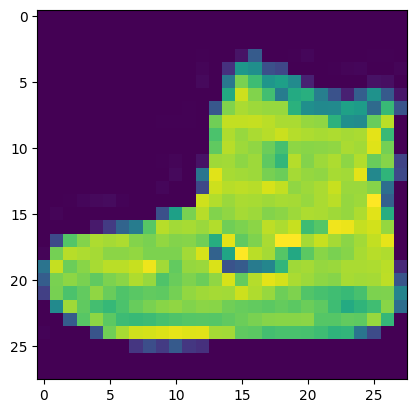

In [15]:
img1 = torch.tensor(np.array(train_data[0][0]))
img2 = torch.tensor(np.array(train_data[1][0]))

img = torch.cat((img1.unsqueeze(0), img2.unsqueeze(0)), dim = 0)
print(img.shape)
plt.imshow(img1.squeeze(0))
plt.show()

In [153]:
tokenizer = MambaTokenizer(28, 256, pos_emb = 'learned', img_channels = 1)
out = tokenizer(img)
print(out.shape)

torch.Size([2, 784, 256])


In [9]:
x = torch.tensor([[[1, 2, 3, 4, 5], [6, 7, 8, 9, 10]]])
x = torch.transpose(x, 1, 2)
print(x.reshape(1, 10,))

tensor([[ 1,  6,  2,  7,  3,  8,  4,  9,  5, 10]])


In [6]:
def scan(x):
    return x.reshape(x.shape[0], -1).unsqueeze(2)

In [16]:
model = MambaCLS(input_size = 1, token_dim = 256, output_size = 10).to(device)
model.eval()

test_input = torch.randn((1, 28, 28)).to(device)
test_input = scan(test_input)
out = model(test_input)

print(out.shape)

NameError: name 'MambaCLS' is not defined

In [8]:
losses = []
pickle.dump(losses, open('./cls_losses.pkl', "wb"))

In [15]:
def train():
    # ======= Model Setup =======
    model_dim = 128
    num_classes = 10
    ofcount = 0

    model = MambaCLS(input_size = 1, token_dim = 256, output_size = num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # ======= Training Loop =======
    losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience = 5              # How many epochs to wait before considering convergence
    epochs_no_improve = 0     # Counter for early stopping
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for imgs, labels in tqdm(train_loader):
            imgs = imgs.to(device)
            labels = labels.to(device)
            #x = patchify(imgs, patch_size)  # (B, N, D)
            x = scan(imgs)
            preds = model(x)
            loss = criterion(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            
        losses.append(total_loss / len(train_loader))
        pickle.dump(losses, open('./cls_losses.pkl', "wb"))
        print(f"[Epoch {epoch+1}] Train Loss: {total_loss / len(train_loader):.4f}")

        # Eval
        model.eval()
        correct = 0
        total = 0
        total_val_loss = 0
        with torch.no_grad():
            for imgs, labels in tqdm(test_loader):
                imgs = imgs.to(device)
                labels = labels.to(device)
                x = scan(imgs)
                preds = model(x)
                loss = criterion(preds, labels)
                total_val_loss += loss.item()
                pred_labels = preds.argmax(dim=1)
                correct += (pred_labels == labels).sum().item()
                total += labels.size(0)

        val_loss = total_val_loss/len(test_loader)
        val_losses.append(val_loss)
        pickle.dump(val_losses, open('./cls_val_losses.pkl', "wb"))
        acc = correct / total
        print(f"[Epoch {epoch+1}] Test Accuracy: {acc:.2%}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            checkpoint = {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': total_loss,
                    # Add other relevant information as needed
                }
            model_file = f'./mamba_cls_models/mamba_cls_epoch_{epoch}.pth'
            torch.save(checkpoint, model_file)
            print("Validation loss improved. Model saved.")
        else:
            epochs_no_improve += 1
            print(f"No improvement for {epochs_no_improve} epoch(s).")
    
        # Check for convergence
        if epochs_no_improve >= patience:
            print("Early stopping: Validation loss has converged.")
            break
    


In [16]:
train()

100%|██████████| 938/938 [02:30<00:00,  6.25it/s]


[Epoch 1] Train Loss: 0.8159


100%|██████████| 157/157 [00:08<00:00, 18.76it/s]


[Epoch 1] Test Accuracy: 80.42%
Validation loss improved. Model saved.


100%|██████████| 938/938 [02:30<00:00,  6.24it/s]


[Epoch 2] Train Loss: 0.4669


100%|██████████| 157/157 [00:08<00:00, 18.74it/s]


[Epoch 2] Test Accuracy: 84.62%
Validation loss improved. Model saved.


100%|██████████| 938/938 [02:30<00:00,  6.25it/s]


[Epoch 3] Train Loss: 0.3932


100%|██████████| 157/157 [00:08<00:00, 18.76it/s]


[Epoch 3] Test Accuracy: 86.12%
Validation loss improved. Model saved.


100%|██████████| 938/938 [02:30<00:00,  6.22it/s]


[Epoch 4] Train Loss: 0.3496


100%|██████████| 157/157 [00:08<00:00, 18.72it/s]


[Epoch 4] Test Accuracy: 86.29%
Validation loss improved. Model saved.


100%|██████████| 938/938 [02:32<00:00,  6.17it/s]


[Epoch 5] Train Loss: 0.3215


100%|██████████| 157/157 [00:08<00:00, 18.76it/s]


[Epoch 5] Test Accuracy: 87.61%
Validation loss improved. Model saved.


100%|██████████| 938/938 [02:31<00:00,  6.17it/s]


[Epoch 6] Train Loss: 0.2992


100%|██████████| 157/157 [00:08<00:00, 18.71it/s]


[Epoch 6] Test Accuracy: 89.06%
Validation loss improved. Model saved.


100%|██████████| 938/938 [02:30<00:00,  6.24it/s]


[Epoch 7] Train Loss: 0.2811


100%|██████████| 157/157 [00:08<00:00, 18.75it/s]


[Epoch 7] Test Accuracy: 89.41%
Validation loss improved. Model saved.


100%|██████████| 938/938 [02:30<00:00,  6.25it/s]


[Epoch 8] Train Loss: 0.2895


100%|██████████| 157/157 [00:08<00:00, 18.74it/s]


[Epoch 8] Test Accuracy: 89.77%
Validation loss improved. Model saved.


100%|██████████| 938/938 [02:30<00:00,  6.23it/s]


[Epoch 9] Train Loss: 0.2523


100%|██████████| 157/157 [00:08<00:00, 18.76it/s]


[Epoch 9] Test Accuracy: 89.09%
No improvement for 1 epoch(s).


100%|██████████| 938/938 [02:30<00:00,  6.23it/s]


[Epoch 10] Train Loss: 0.2568


100%|██████████| 157/157 [00:08<00:00, 18.75it/s]


[Epoch 10] Test Accuracy: 90.53%
Validation loss improved. Model saved.


100%|██████████| 938/938 [02:31<00:00,  6.20it/s]


[Epoch 11] Train Loss: 0.2943


100%|██████████| 157/157 [00:08<00:00, 18.69it/s]


[Epoch 11] Test Accuracy: 89.72%
No improvement for 1 epoch(s).


100%|██████████| 938/938 [02:31<00:00,  6.17it/s]


[Epoch 12] Train Loss: 0.2373


100%|██████████| 157/157 [00:08<00:00, 18.33it/s]


[Epoch 12] Test Accuracy: 90.69%
No improvement for 2 epoch(s).


100%|██████████| 938/938 [02:30<00:00,  6.24it/s]


[Epoch 13] Train Loss: 0.2252


100%|██████████| 157/157 [00:08<00:00, 18.76it/s]


[Epoch 13] Test Accuracy: 90.91%
Validation loss improved. Model saved.


100%|██████████| 938/938 [02:30<00:00,  6.23it/s]


[Epoch 14] Train Loss: 0.2160


100%|██████████| 157/157 [00:08<00:00, 18.77it/s]


[Epoch 14] Test Accuracy: 90.16%
No improvement for 1 epoch(s).


100%|██████████| 938/938 [02:30<00:00,  6.24it/s]


[Epoch 15] Train Loss: 0.2696


100%|██████████| 157/157 [00:08<00:00, 18.76it/s]


[Epoch 15] Test Accuracy: 90.70%
No improvement for 2 epoch(s).


100%|██████████| 938/938 [02:30<00:00,  6.24it/s]


[Epoch 16] Train Loss: 0.2055


100%|██████████| 157/157 [00:08<00:00, 18.77it/s]


[Epoch 16] Test Accuracy: 91.46%
Validation loss improved. Model saved.


100%|██████████| 938/938 [02:30<00:00,  6.24it/s]


[Epoch 17] Train Loss: 0.1991


100%|██████████| 157/157 [00:08<00:00, 18.77it/s]


[Epoch 17] Test Accuracy: 91.29%
No improvement for 1 epoch(s).


100%|██████████| 938/938 [02:30<00:00,  6.23it/s]


[Epoch 18] Train Loss: 0.3655


100%|██████████| 157/157 [00:08<00:00, 18.80it/s]


[Epoch 18] Test Accuracy: 32.51%
No improvement for 2 epoch(s).


100%|██████████| 938/938 [02:30<00:00,  6.23it/s]


[Epoch 19] Train Loss: 0.7545


100%|██████████| 157/157 [00:08<00:00, 18.77it/s]


[Epoch 19] Test Accuracy: 80.55%
No improvement for 3 epoch(s).


100%|██████████| 938/938 [02:30<00:00,  6.23it/s]


[Epoch 20] Train Loss: 0.4686


100%|██████████| 157/157 [00:08<00:00, 18.77it/s]

[Epoch 20] Test Accuracy: 83.96%
No improvement for 4 epoch(s).
